In [72]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [73]:
! pip install -q kaggle

In [75]:
# Download dataset from Kaggle
# !kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd --force


# Unzip the downloaded dataset
!unzip -q driver-drowsiness-dataset-ddd.zip

# List the files in the current directory
!ls


Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown
100%|██████████████████████████████████████| 2.58G/2.58G [01:23<00:00, 35.0MB/s]
100%|██████████████████████████████████████| 2.58G/2.58G [01:23<00:00, 33.1MB/s]
replace Driver Drowsiness Dataset (DDD)/Drowsy/A0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
'Driver Drowsiness Dataset (DDD)'   driver-drowsiness-dataset-ddd.zip
 best_model.keras


In [5]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [6]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    r"Driver Drowsiness Dataset (DDD)",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 41793 files belonging to 2 classes.
Using 33435 files for training.
Using 8358 files for validation.


In [7]:
!ls

'Driver Drowsiness Dataset (DDD)'   driver-drowsiness-dataset-ddd.zip


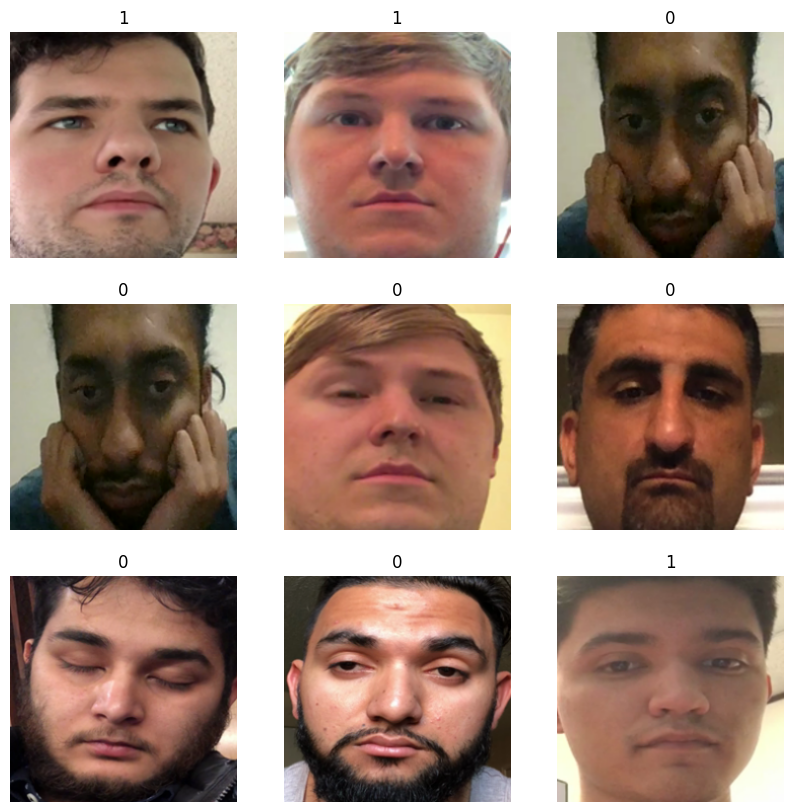

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

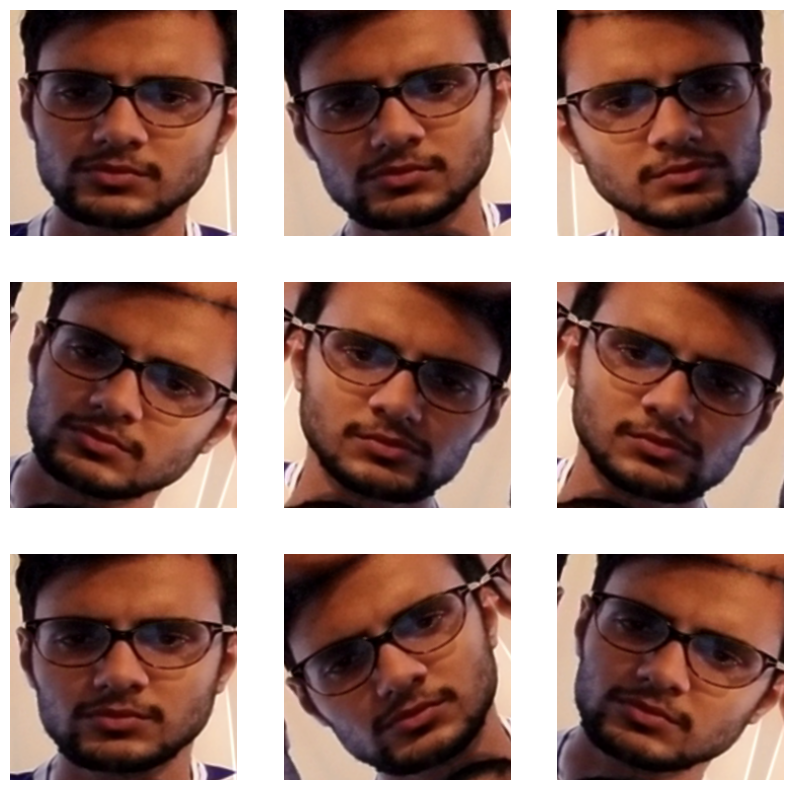

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [12]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(tf.image.resize(img, (224, 224))), label),
    num_parallel_calls=tf_data.AUTOTUNE,)
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Model-1

VGG16

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 model layers so they aren't trained
# Add a Input layer to define the input shape of the model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # This line was added
    vgg_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,203,521 (80.89 MB)

 Trainable params: 21,203,521 (80.89 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

# print(train_datagen.shape)
# print(val_datagen.shape)

This is to resize The Dataset


In [22]:
import os
import random
import shutil

def reduce_dataset(original_dir, reduced_dir, total_samples):
    os.makedirs(reduced_dir, exist_ok=True)
    
    # Get class directories
    class_dirs = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]
    total_classes = len(class_dirs)
    
    # Calculate how many samples to take from each class
    samples_per_class = total_samples // total_classes
    
    for class_dir in class_dirs:
        class_path = os.path.join(original_dir, class_dir)
        # Create class directory in reduced dataset
        os.makedirs(os.path.join(reduced_dir, class_dir), exist_ok=True)
        
        # List all images in class directory
        images = os.listdir(class_path)
        
        # Randomly sample images
        sampled_images = random.sample(images, min(samples_per_class, len(images)))
        
        for image in sampled_images:
            src = os.path.join(class_path, image)
            dst = os.path.join(reduced_dir, class_dir, image)
            shutil.copy(src, dst)

# Example usage
original_dataset_path = "Driver Drowsiness Dataset (DDD)"
reduced_dataset_path = "Reduced_Driver_Drowsiness_Dataset"
reduce_dataset(original_dataset_path, reduced_dataset_path, total_samples=10000)  # Set total samples to 2000


In [26]:
from keras import callbacks
import tensorflow as tf
from tensorflow.keras import layers, models


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")])

# Create image data generators
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
)

# Set up the training generator
train_generator = train_datagen.flow_from_directory(
    r"Reduced_Driver_Drowsiness_Dataset",
    target_size=(224, 224),
    batch_size=32,  # Experiment with batch size
    class_mode='binary'
)

# Set up the validation generator (without augmentation)
validation_generator = val_datagen.flow_from_directory(
    r"Reduced_Driver_Drowsiness_Dataset",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Train the model with increased epochs
history = model.fit(
    train_generator,
    epochs=10,  # Increase the number of epochs
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 3892 images belonging to 2 classes.
Found 3892 images belonging to 2 classes.
Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 78s 550ms/step - accuracy: 0.4835 - loss: 0.6944 - val_accuracy: 0.5023 - val_loss: 0.6932
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 67s 522ms/step - accuracy: 0.4991 - loss: 0.6935 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 65s 510ms/step - accuracy: 0.4901 - loss: 0.6934 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 67s 523ms/step - accuracy: 0.5093 - loss: 0.6929 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 66s 514ms/step - accuracy: 0.5215 - loss: 0.6930 - val_accuracy: 0.4977 - val_loss: 0.6932
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 66s 514ms/step - accuracy: 0.4815 - loss: 0.6934 - val_accuracy: 0.5023 - val_loss: 0.6931
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 66s 514ms/step - accuracy: 0.4908 - loss: 0.6933 - val_accuracy: 0.5023 - val_loss: 0.6931

In [28]:
from keras import callbacks
epochs = 5

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your training data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your validation data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 41793 images belonging to 2 classes.
Found 41793 images belonging to 2 classes.
Epoch 1/5
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 636s 479ms/step - accuracy: 0.5278 - loss: 0.6917 - val_accuracy: 0.5347 - val_loss: 0.6908
Epoch 2/5
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 621s 473ms/step - accuracy: 0.5351 - loss: 0.6908 - val_accuracy: 0.5347 - val_loss: 0.6907
Epoch 3/5
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 617s 470ms/step - accuracy: 0.5358 - loss: 0.6907 - val_accuracy: 0.5347 - val_loss: 0.6907
Epoch 4/5
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 623s 475ms/step - accuracy: 0.5362 - loss: 0.6907 - val_accuracy: 0.5347 - val_loss: 0.6907
Epoch 5/5
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 674s 469ms/step - accuracy: 0.5319 - loss: 0.6912 - val_accuracy: 0.5347 - val_loss: 0.6907


In [11]:
from keras import callbacks
epochs = 2

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your training data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your validation data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 41793 images belonging to 2 classes.
Found 41793 images belonging to 2 classes.
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726935346.751701   13011 service.cc:145] XLA service 0x79778c0015b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726935346.751800   13011 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726935369.289566  

1307/1307 ━━━━━━━━━━━━━━━━━━━━ 693s 507ms/step - accuracy: 0.5290 - loss: 0.7005 - val_accuracy: 0.5347 - val_loss: 0.6907
Epoch 2/2
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 613s 467ms/step - accuracy: 0.5358 - loss: 0.6905 - val_accuracy: 0.5347 - val_loss: 0.6907


1307/1307 ━━━━━━━━━━━━━━━━━━━━ 126s 96ms/step - accuracy: 0.5351 - loss: 0.6907
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 122s 93ms/step
Validation Loss: 0.6907
Validation Accuracy: 0.5347
Precision: 0.4653
Recall: 1.0000
F1 Score: 0.6351


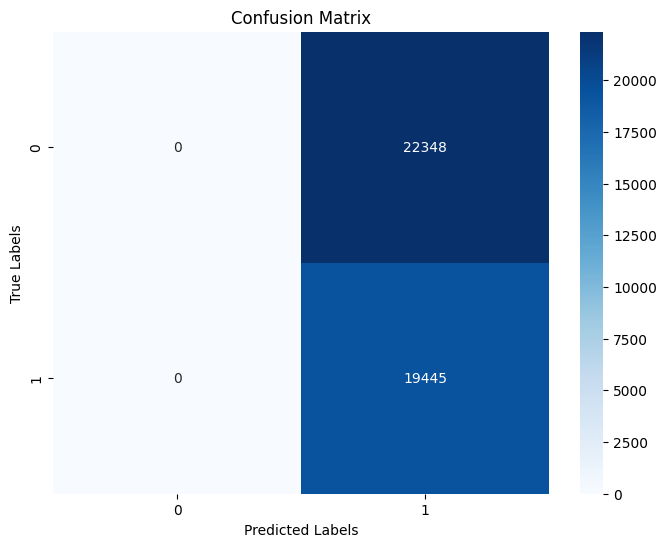

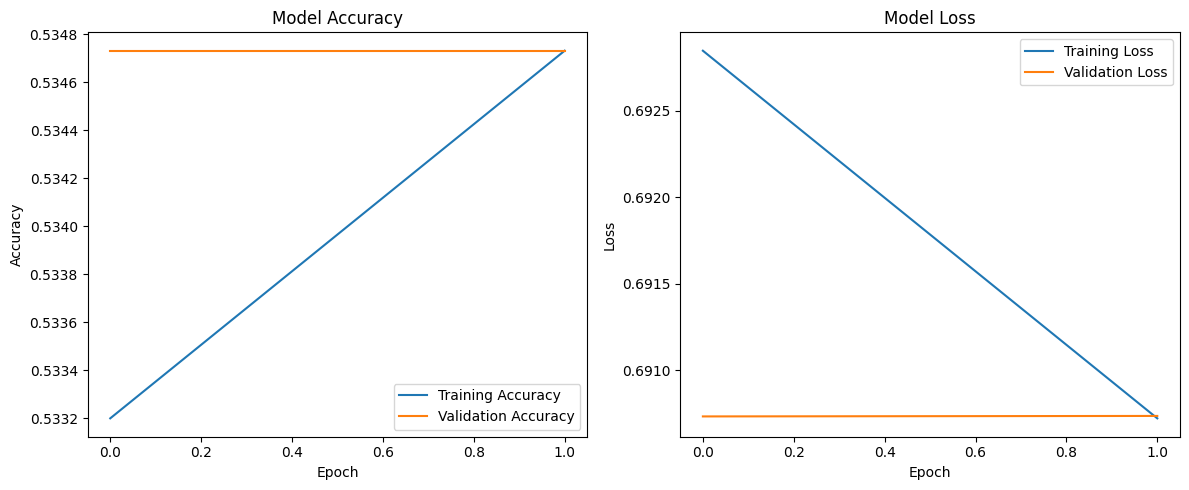

In [12]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(validation_generator)

# Step 2: Make predictions on validation data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model.predict(validation_generator)

# Adjust threshold
threshold = 0.3  # Try a lower threshold
predicted_classes = (predictions > threshold).astype("int32")  # Threshold at 0.3

# Step 3: Get the true labels
true_classes = validation_generator.classes  # True labels

# Step 4: Calculate precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes, zero_division=1)  # Handle undefined metrics
recall = recall_score(true_classes, predicted_classes, zero_division=1)
f1 = f1_score(true_classes, predicted_classes, zero_division=1)

# Step 5: Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 7: Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model-2

VGG 19

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import VGG19
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the VGG-19 model with pre-trained weights on ImageNet
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG19 model layers so they aren't trained
for layer in vgg19_model.layers:
    layer.trainable = False

# Create a sequential model using the frozen VGG19 base and adding custom layers on top
model2 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  # Input layer to define the shape
    vgg19_model,  # VGG19 base model
    layers.Flatten(),  # Flatten the output from VGG19
    layers.Dense(256, activation='relu'),  # Fully connected layer with 256 units
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model2.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,480,193 (101.01 MB)

 Trainable params: 6,455,809 (24.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [17]:
from keras import callbacks
epochs = 2

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your training data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your validation data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model2.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 41793 images belonging to 2 classes.
Found 41793 images belonging to 2 classes.
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1307/1307 ━━━━━━━━━━━━━━━━━━━━ 619s 468ms/step - accuracy: 0.8260 - loss: 0.3783 - val_accuracy: 0.9972 - val_loss: 0.0089
Epoch 2/2
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 610s 465ms/step - accuracy: 0.9463 - loss: 0.1034 - val_accuracy: 0.9956 - val_loss: 0.0128


1307/1307 ━━━━━━━━━━━━━━━━━━━━ 128s 98ms/step - accuracy: 0.9954 - loss: 0.0131
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 120s 91ms/step
Validation Loss: 0.0128
Validation Accuracy: 0.9956
Precision: 0.4658
Recall: 0.4722
F1 Score: 0.4690


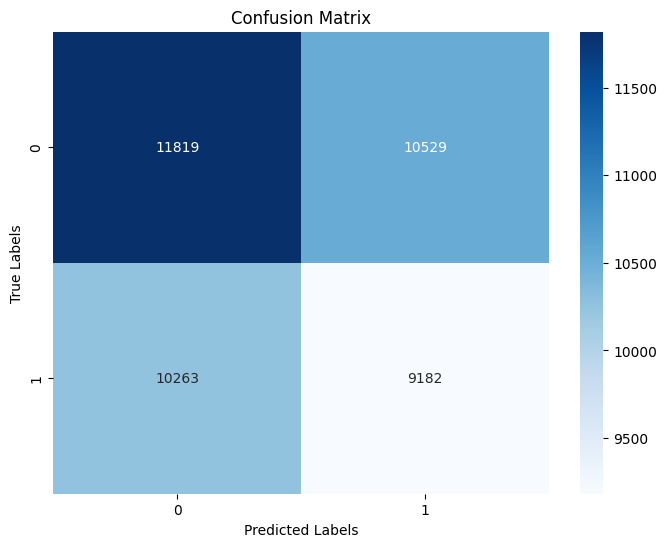

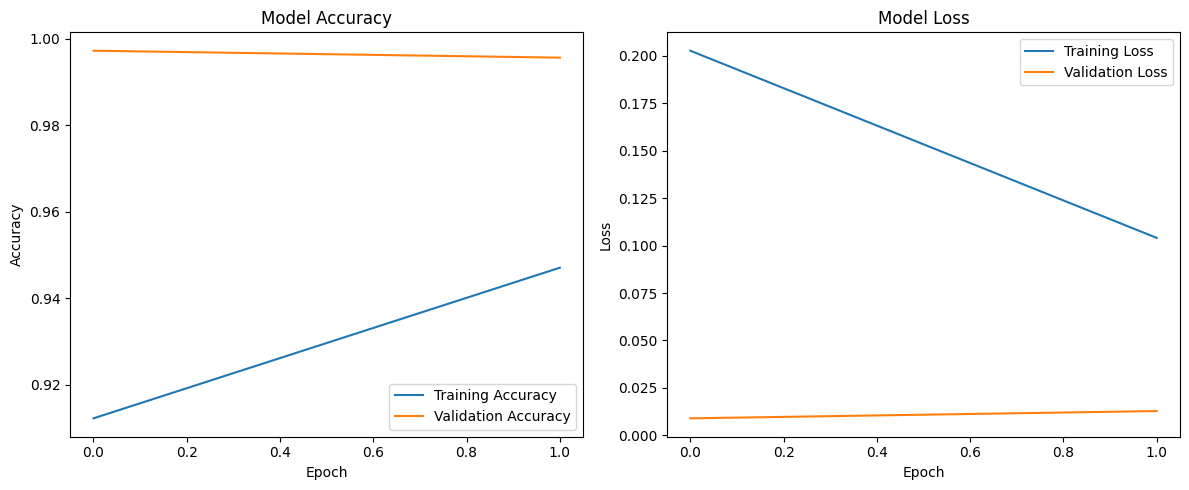

In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Evaluate the model on the validation data
val_loss, val_accuracy = model2.evaluate(validation_generator)

# Step 2: Make predictions on validation data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model2.predict(validation_generator)

# Adjust threshold
threshold = 0.3  # Try a lower threshold
predicted_classes = (predictions > threshold).astype("int32")  # Threshold at 0.3

# Step 3: Get the true labels
true_classes = validation_generator.classes  # True labels

# Step 4: Calculate precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes, zero_division=1)  # Handle undefined metrics
recall = recall_score(true_classes, predicted_classes, zero_division=1)
f1 = f1_score(true_classes, predicted_classes, zero_division=1)

# Step 5: Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 7: Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model-3

AlexNet


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build AlexNet model based on the architecture shown in the image
model3 = models.Sequential([
    # Input layer to define the shape
    layers.Input(shape=(224, 224, 3)),

    # 1st Convolutional Layer + Max Pooling
    layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # 2nd Convolutional Layer + Max Pooling
    layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # 3rd Convolutional Layer
    layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),

    # 4th Convolutional Layer
    layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),

    # 5th Convolutional Layer + Max Pooling
    layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    # Use GlobalAveragePooling instead of Flatten
    layers.GlobalAveragePooling2D(),

    # Fully connected layers
    layers.Dense(4096, activation='relu'),  # First fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(4096, activation='relu'),  # Second fully connected layer
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model3.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,585,281 (82.34 MB)

 Trainable params: 21,585,281 (82.34 MB)

 Non-trainable params: 0 (0.00 B)

If i use Flatten It getting error so i use AvePooling

Option 1: Uses Flatten() but ensures the input size to the fully connected layers is dynamically calculated.

Option 2: Uses GlobalAveragePooling2D() to avoid dealing with input size mismatch, which automatically handles the spatial dimensions.

In [28]:
from keras import callbacks
epochs = 2

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your training data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  # Replace with your validation data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model3.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 41793 images belonging to 2 classes.
Found 41793 images belonging to 2 classes.
Epoch 1/2
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 702s 531ms/step - accuracy: 0.5333 - loss: 0.6923 - val_accuracy: 0.6227 - val_loss: 0.6381
Epoch 2/2
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 685s 522ms/step - accuracy: 0.7696 - loss: 0.4510 - val_accuracy: 0.9903 - val_loss: 0.0409


1307/1307 ━━━━━━━━━━━━━━━━━━━━ 125s 96ms/step - accuracy: 0.9901 - loss: 0.0407
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 117s 89ms/step
Validation Loss: 0.0409
Validation Accuracy: 0.9903
Precision: 0.4665
Recall: 0.4758
F1 Score: 0.4711


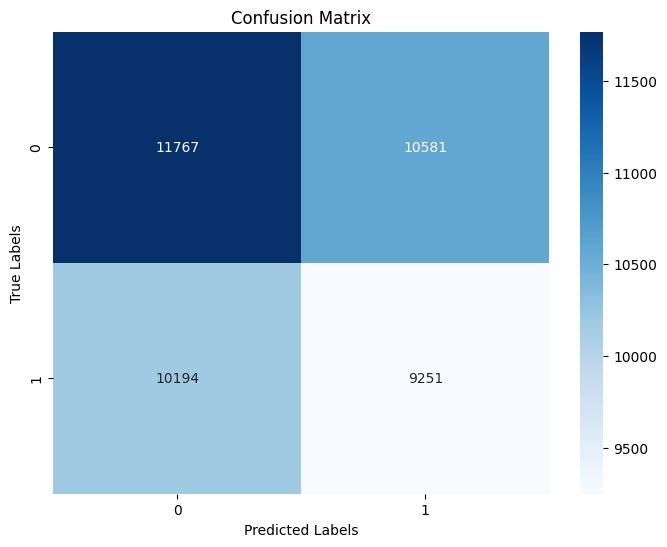

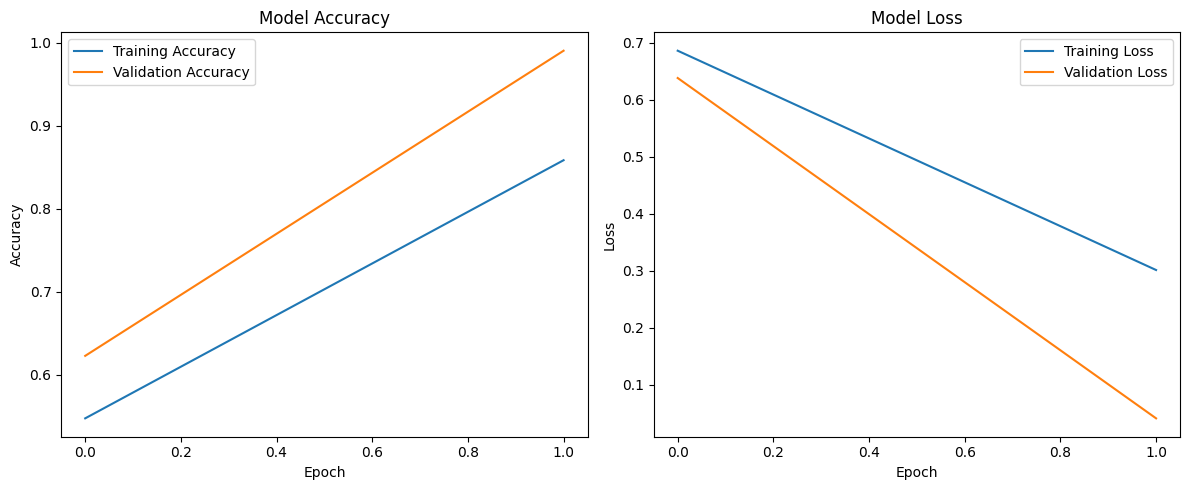

In [29]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Evaluate the model on the validation data
val_loss, val_accuracy = model3.evaluate(validation_generator)

# Step 2: Make predictions on validation data
validation_generator.reset()  # Reset the generator to start from the beginning
predictions = model3.predict(validation_generator)

# Adjust threshold
threshold = 0.3  # Try a lower threshold
predicted_classes = (predictions > threshold).astype("int32")  # Threshold at 0.3

# Step 3: Get the true labels
true_classes = validation_generator.classes  # True labels

# Step 4: Calculate precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes, zero_division=1)  # Handle undefined metrics
recall = recall_score(true_classes, predicted_classes, zero_division=1)
f1 = f1_score(true_classes, predicted_classes, zero_division=1)

# Step 5: Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 7: Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model-4

ResNet9

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet_block(input_tensor, filters):
    # First convolution layer
    x = layers.Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), padding='same')(input_tensor)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    
    return x

def create_resnet9(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(16, (3, 3), padding='same')(inputs)  # Layer 1
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # ResNet Blocks
    x = resnet_block(x, 16)  # Layer 2, 3
    x = resnet_block(x, 32)  # Layer 4, 5
    x = resnet_block(x, 64)  # Layer 6, 7

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)  # Layer 8

    # Fully Connected Layer
    x = layers.Dense(1024, activation='relu')(x)  # Layer 9

    # Output Layer for Binary Classification
    predictions = layers.Dense(2, activation='sigmoid')(x)  # Output Layer

    # Create the final model
    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Define input shape
input_shape = (224, 224, 3)

# Create the ResNet9 model
model4 = create_resnet9(input_shape)

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model4.summary()


Model: "functional_156"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 224, 224,  │        448 │ input_layer_38[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_140[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_71 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_141 (Conv2D) │ (None, 224, 224,  │      2,320 │ re_lu_71[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_141[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_142 (Conv2D) │ (None, 224, 224,  │      2,320 │ re_lu_72[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         64 │ conv2d_142[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │ re_lu_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 224, 224,  │          0 │ add_32[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_143 (Conv2D) │ (None, 224, 224,  │      4,640 │ re_lu_73[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_143[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_144 (Conv2D) │ (None, 224, 224,  │      9,248 │ re_lu_74[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_144[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_145 (Conv2D) │ (None, 224, 224,  │        544 │ re_lu_73[0][0]  

 Total params: 146,626 (572.76 KB)

 Trainable params: 146,146 (570.88 KB)

 Non-trainable params: 480 (1.88 KB)

In [87]:
from keras import callbacks
epochs = 2

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model4.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 41793 images belonging to 2 classes.
Found 41793 images belonging to 2 classes.
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-22 05:01:00.514222: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,64,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackward

1307/1307 ━━━━━━━━━━━━━━━━━━━━ 719s 530ms/step - accuracy: 0.8668 - loss: 0.2997 - val_accuracy: 0.9476 - val_loss: 0.1664
Epoch 2/2
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 688s 524ms/step - accuracy: 0.9647 - loss: 0.0973 - val_accuracy: 0.9812 - val_loss: 0.0566


1307/1307 ━━━━━━━━━━━━━━━━━━━━ 126s 96ms/step - accuracy: 0.9818 - loss: 0.0565
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 121s 93ms/step
Length of true_classes: 41793
Length of predicted_classes: 83584
Validation Loss: 0.0566
Validation Accuracy: 0.9812
Precision: 0.4652
Recall: 0.4999
F1 Score: 0.4820


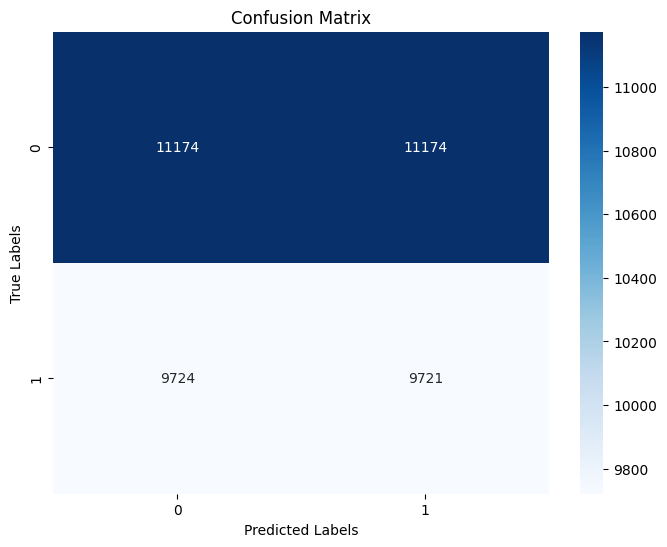

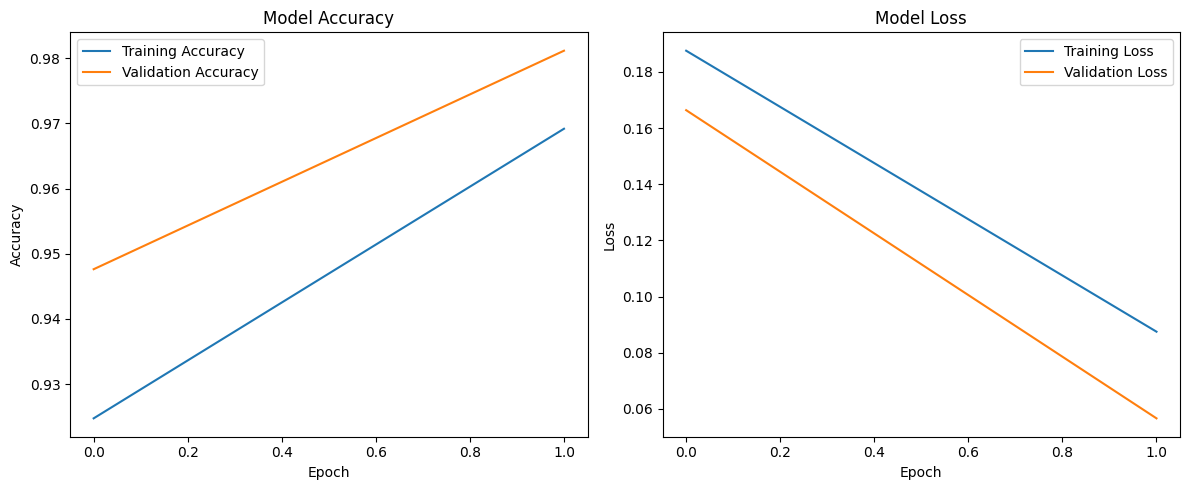

In [90]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Evaluate the model on the validation data
val_loss, val_accuracy = model4.evaluate(validation_generator)

# # Step 2: Make predictions on validation data
# validation_generator.reset()  # Reset the generator to start from the beginning
# predictions = model4.predict(validation_generator)

# # Adjust threshold using rounding
# predicted_classes = np.round(predictions).astype("int32")  # Round predictions to get binary classes

# Step 3: Get the true labels
true_classes = validation_generator.classes  # True labels

steps = validation_generator.samples // validation_generator.batch_size
predictions = model4.predict(validation_generator, steps=steps, verbose=1)

# Convert predictions to binary class labels
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Check the lengths of both arrays
print("Length of true_classes:", len(true_classes))
print("Length of predicted_classes:", len(predicted_classes))

# Ensure lengths match
if len(predicted_classes) > len(true_classes):
    predicted_classes = predicted_classes[:len(true_classes)]
elif len(predicted_classes) < len(true_classes):
    print("Warning: Predicted classes are fewer than true classes.")

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, zero_division=1)
recall = recall_score(true_classes, predicted_classes, zero_division=1)
f1 = f1_score(true_classes, predicted_classes, zero_division=1)

# Output results
# Step 5: Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 6: Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 7: Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Model-5

ResNet50

In [92]:
import tensorflow as tf
from tensorflow.keras import layers, models

def resnet_block(input_tensor, filters, strides=(1, 1), downsample=None):
    # First convolution layer
    x = layers.Conv2D(filters, (3, 3), padding='same', strides=strides)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Skip connection
    if downsample is not None:
        input_tensor = downsample(input_tensor)

    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    
    return x

def create_resnet50(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, (7, 7), padding='same', strides=(2, 2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # ResNet Blocks
    # Block 1
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    # Block 2
    x = resnet_block(x, 128, strides=(2, 2), downsample=lambda x: layers.Conv2D(128, (1, 1), strides=(2, 2))(x))
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)

    # Block 3
    x = resnet_block(x, 256, strides=(2, 2), downsample=lambda x: layers.Conv2D(256, (1, 1), strides=(2, 2))(x))
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)

    # Block 4
    x = resnet_block(x, 512, strides=(2, 2), downsample=lambda x: layers.Conv2D(512, (1, 1), strides=(2, 2))(x))
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(1024, activation='relu')(x)

    # Output Layer for Binary Classification
    predictions = layers.Dense(2, activation='sigmoid')(x)

    # Create the final model
    model = models.Model(inputs=inputs, outputs=predictions)
    return model

# Define input shape
input_shape = (224, 224, 3)

# Create the ResNet50 model
model5 = create_resnet50(input_shape)

# Compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model5.summary()


Model: "functional_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_185 (Conv2D) │ (None, 112, 112,  │      9,472 │ input_layer_40[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_185[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_111 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 56, 56,    │          0 │ re_lu_111[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_186 (Conv2D) │ (None, 56, 56,    │     36,928 │ max_pooling2d_33… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_186[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_112 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_187 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_112[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_187[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_51 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_113 (ReLU)    │ (None, 56, 56,    │          0 │ add_51[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_113[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_114 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 56, 56,    │     36,928 │ re_lu_114[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_189[0][0]

 Total params: 21,833,986 (83.29 MB)

 Trainable params: 21,818,754 (83.23 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [ ]:
from keras import callbacks
epochs = 2

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    r"Driver Drowsiness Dataset (DDD)",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy")],
)
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True, mode="min"),
    callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
]
history = model5.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks_list,
    validation_data=validation_generator
)

Found 41793 images belonging to 2 classes.
Found 41793 images belonging to 2 classes.
Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/1307 ━━━━━━━━━━━━━━━━━━━━ 13:06:37 36s/step - accuracy: 0.6719 - loss: 0.6641

I0000 00:00:1726983314.441575     131 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_42', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads



 745/1307 ━━━━━━━━━━━━━━━━━━━━ 4:11 448ms/step - accuracy: 0.8732 - loss: 0.3146

I0000 00:00:1726983647.605001     131 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_67', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_66', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_65', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_61', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_60', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_59', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_58', 4 by

1307/1307 ━━━━━━━━━━━━━━━━━━━━ 734s 535ms/step - accuracy: 0.9042 - loss: 0.2424 - val_accuracy: 0.9837 - val_loss: 0.0471
Epoch 2/2
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9877 - loss: 0.0365

1307/1307 ━━━━━━━━━━━━━━━━━━━━ 121s 93ms/step - accuracy: 0.9814 - loss: 0.0581
1306/1306 ━━━━━━━━━━━━━━━━━━━━ 116s 89ms/step
Length of true_classes: 41793
Length of predicted_classes: 83584 

Validation Loss: 0.0566
Validation Accuracy: 0.9812
Precision: 0.4653
Recall: 0.5000
F1 Score: 0.4820


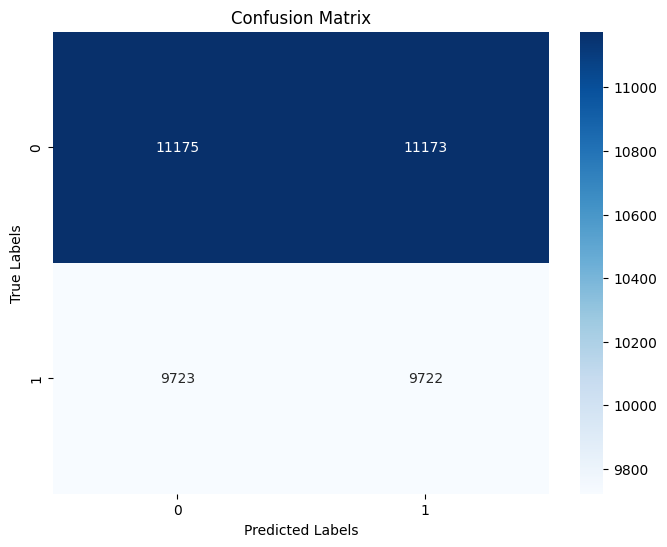

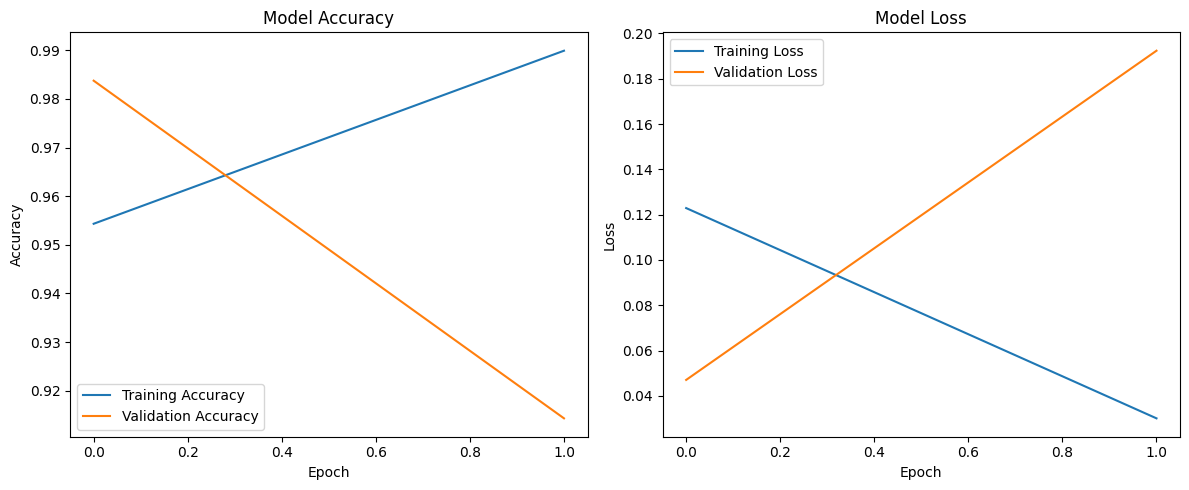

In [94]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# Step 1: Evaluate the model on the validation data
val_loss, val_accuracy = model4.evaluate(validation_generator)

# # Step 2: Make predictions on validation data
# validation_generator.reset()  # Reset the generator to start from the beginning
# predictions = model4.predict(validation_generator)

# # Adjust threshold using rounding
# predicted_classes = np.round(predictions).astype("int32")  # Round predictions to get binary classes

# Step 3: Get the true labels
true_classes = validation_generator.classes  # True labels

steps = validation_generator.samples // validation_generator.batch_size
predictions = model4.predict(validation_generator, steps=steps, verbose=1)

# Convert predictions to binary class labels
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Check the lengths of both arrays
print("Length of true_classes:", len(true_classes))
print("Length of predicted_classes:", len(predicted_classes),"\n")

# Ensure lengths match
if len(predicted_classes) > len(true_classes):
    predicted_classes = predicted_classes[:len(true_classes)]
elif len(predicted_classes) < len(true_classes):
    print("Warning: Predicted classes are fewer than true classes.")

# Calculate metrics
precision = precision_score(true_classes, predicted_classes, zero_division=1)
recall = recall_score(true_classes, predicted_classes, zero_division=1)
f1 = f1_score(true_classes, predicted_classes, zero_division=1)

# Output results
# Step 5: Print the results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 6: Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Step 7: Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
